## Student Information

In [1]:
# Student Name: Daniel Nemirovskiy, Nathan Seaney
# Student ID: DEN200001, 
# Course Name: CS 4375-002

## Importing Necessary Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy
import random
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

## Setting GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Creating Directories for Results

In [4]:
os.makedirs('./results', exist_ok=True)
os.makedirs('./results/runs', exist_ok=True)

## Obtaining the Datasets

In [5]:
def get_datasets(dataset_name, batch_size=32, num_workers=2):
    """
    Load and preprocess datasets. Split training data into train and validation sets.
    
    Args:
        dataset_name (str): Name of the dataset to load ('cifar10' or 'svhn')
        batch_size (int): Batch size for dataloaders
        num_workers (int): Number of worker threads for dataloaders
        
    Returns:
        train_loader, val_loader, test_loader: DataLoader objects for training, validation, and test sets
        dataset_info (dict): Information about the dataset (e.g., classes, input shape)
    """
    # Define transformations
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Load dataset
    if dataset_name.lower() == 'cifar10':
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                                    download=True, transform=transform_train)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                                   download=True, transform=transform_test)
        dataset_info = {
            'name': 'CIFAR-10',
            'num_classes': 10,
            'classes': ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
            'input_channels': 3,
            'input_shape': (32, 32)
        }
        
    elif dataset_name.lower() == 'svhn':
        train_dataset = torchvision.datasets.SVHN(root='./data', split='train',
                                                download=True, transform=transform_train)
        test_dataset = torchvision.datasets.SVHN(root='./data', split='test',
                                               download=True, transform=transform_test)
        dataset_info = {
            'name': 'SVHN',
            'num_classes': 10,
            'classes': tuple(str(i) for i in range(10)),  # Digits 0-9
            'input_channels': 3,
            'input_shape': (32, 32)
        }
    else:
        raise ValueError(f"Dataset {dataset_name} not supported. Use 'cifar10' or 'svhn'.")
    
    # Split training data into training and validation sets (90% train, 10% val)
    val_size = int(0.1 * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size,
                             shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_subset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)
    
    print(f"Dataset: {dataset_info['name']}")
    print(f"Number of training samples: {len(train_subset)}")
    print(f"Number of validation samples: {len(val_subset)}")
    print(f"Number of testing samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader, dataset_info

## Visualizing the Data Samples

In [6]:
def visualize_dataset_samples(loader, classes, num_samples=5):
    """
    Visualize samples from a dataset.
    
    Args:
        loader: DataLoader to get samples from
        classes: List of class names
        num_samples: Number of samples to visualize per class
    """
    samples, labels = next(iter(loader))
    
    # Move samples to CPU and convert to numpy
    samples = samples.cpu().numpy()
    
    # Unnormalize images
    samples = samples / 2 + 0.5
    
    # Plot samples
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(samples))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(np.transpose(samples[i], (1, 2, 0)))
        plt.title(classes[labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Showing {num_samples} sample images from dataset")

## Implementing the LeNet Model

In [7]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(LeNet, self).__init__()
        # Layer 1: Convolutional layer with 6 filters of size 5x5, followed by ReLU and 2x2 max pooling
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5, padding=2)  # Padding=2 to preserve spatial dimensions
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 2: Convolutional layer with 16 filters of size 5x5, followed by ReLU and 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate size after convolutions and pooling for a 32x32 input image
        # After conv1 + pool1: 32x32 -> 16x16
        # After conv2 + pool2: 16x16 -> 6x6 (due to no padding in conv2)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        # First convolutional block
        x = self.pool1(F.relu(self.conv1(x)))
        
        # Second convolutional block
        x = self.pool2(F.relu(self.conv2(x)))
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Test the model with a random input tensor
def test_lenet():
    model = LeNet()
    sample_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
    output = model(sample_input)
    print(f"LeNet Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")


## Implementing the ResNet-18 Model

In [8]:
class BasicBlock(nn.Module):
    """
    Basic block for ResNet-18 and ResNet-34
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        # Main path
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Add shortcut connection
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet18(nn.Module):
    """
    ResNet-18 implementation.
    Original paper: "Deep Residual Learning for Image Recognition" by Kaiming He et al.
    
    Adapted for CIFAR-10 and SVHN datasets with 32x32 images.
    """
    def __init__(self, num_classes=10, input_channels=3):
        super(ResNet18, self).__init__()
        
        # Initial convolutional layer
        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Four layers of the network, each with multiple residual blocks
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Create a layer of residual blocks.
        
        Args:
            block: Block type (BasicBlock for ResNet-18)
            out_channels: Number of output channels
            num_blocks: Number of blocks in this layer
            stride: Stride for the first block (to downsample, if needed)
            
        Returns:
            nn.Sequential: A sequence of residual blocks
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial convolution
        out = F.relu(self.bn1(self.conv1(x)))
        
        # ResNet layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        # Global average pooling
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        
        # Fully connected layer
        out = self.fc(out)
        
        return out

# Test the model with a random input tensor
def test_resnet18():
    model = ResNet18()
    sample_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
    output = model(sample_input)
    print(f"ResNet-18 Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

## Implementing our Custom FCNN

In [9]:
class CustomCNN(nn.Module):
    """
    A custom CNN architecture based on the reference provided.
    This model has three convolutional blocks, each with batch normalization and max pooling,
    followed by two fully connected layers.
    """
    def __init__(self, num_classes=10, input_channels=3):
        super(CustomCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)  # 16 filters, kernel size 5, padding to keep the same spatial size
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization to stabilize learning
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)  # 32 filters, kernel size 5, same padding
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # 64 filters, kernel size 5, same padding
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization

        # Fully Connected Layer
        self.fc1 = nn.Linear(64 * 4 * 4, 256)  # Assuming input is 32x32, after 3 pooling layers it becomes 4x4
        self.fc2 = nn.Linear(256, num_classes)  # Output layer with the number of classes

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First convolutional block with ReLU activation, followed by pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Second convolutional block with ReLU activation, followed by pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Third convolutional block with ReLU activation, followed by pooling
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layer with ReLU activation and dropout
        x = self.dropout(F.relu(self.fc1(x)))

        # Output layer (no activation here because CrossEntropyLoss includes softmax)
        x = self.fc2(x)

        return x

# Test the model with a random input tensor
def test_customcnn():
    model = CustomCNN()
    sample_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
    output = model(sample_input)
    print(f"CustomCNN Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

# Run tests on all models
test_lenet()
test_resnet18()
test_customcnn()

LeNet Test:
  Input shape: torch.Size([1, 3, 32, 32])
  Output shape: torch.Size([1, 10])
  Number of parameters: 83126
ResNet-18 Test:
  Input shape: torch.Size([1, 3, 32, 32])
  Output shape: torch.Size([1, 10])
  Number of parameters: 11173962
CustomCNN Test:
  Input shape: torch.Size([1, 3, 32, 32])
  Output shape: torch.Size([1, 10])
  Number of parameters: 330506


## Model Selector function

In [10]:
# Function to get a model by name
def get_model(model_name, num_classes=10, input_channels=3):
    """
    Return model instance based on name.
    """
    if model_name.lower() == 'lenet':
        return LeNet(num_classes=num_classes, input_channels=input_channels)
    elif model_name.lower() == 'resnet18':
        return ResNet18(num_classes=num_classes, input_channels=input_channels)
    elif model_name.lower() == 'customcnn':
        return CustomCNN(num_classes=num_classes, input_channels=input_channels)
    else:
        raise ValueError(f"Model {model_name} not supported. Use 'lenet', 'resnet18', or 'customcnn'.")


## Defining the Training Function

In [11]:
def train_model(model, dataloaders, criterion, optimizer, device, 
               num_epochs=25, model_name="model", dataset_name="dataset",
               scheduler=None, log_step=100, save_dir="./results"):
    """
    Train a model and evaluate on validation set.
    
    Args:
        model (nn.Module): PyTorch model to train
        dataloaders (dict): Dictionary with 'train' and 'val' dataloaders
        criterion: Loss function
        optimizer: Optimizer for training
        device: Device to train on ('cuda' or 'cpu')
        num_epochs (int): Number of epochs to train
        model_name (str): Name of the model for logging
        dataset_name (str): Name of the dataset for logging
        scheduler: Learning rate scheduler (optional)
        log_step (int): Frequency of logging to TensorBoard
        save_dir (str): Directory to save results
        
    Returns:
        model: Trained model
        history: Dictionary containing training history
    """
    since = time.time()
    
    # Setup TensorBoard writer
    writer = SummaryWriter(f"{save_dir}/runs/{model_name}_{dataset_name}")
    
    # Initialize training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Copy initial model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches
            data_iterator = tqdm(dataloaders[phase], desc=f'{phase} - Epoch {epoch+1}/{num_epochs}')
            for i, (inputs, labels) in enumerate(data_iterator):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        # Log to TensorBoard
                        global_step = epoch * len(dataloaders['train']) + i
                        if global_step % log_step == 0:
                            writer.add_scalar(f'Loss/{phase}', loss.item(), global_step)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Update learning rate if scheduler is provided
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            # Calculate epoch statistics
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # Log epoch statistics
            writer.add_scalar(f'Epoch_Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Epoch_Accuracy/{phase}', epoch_acc, epoch)
            
            # Update history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'accuracy': best_acc,
                }, f"{save_dir}/{model_name}_{dataset_name}_best.pth")
        
        # Save checkpoint after each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, f"{save_dir}/{model_name}_{dataset_name}_checkpoint.pth")
        
        print()
    
    # Calculate total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Add model graph to TensorBoard
    writer.add_graph(model, next(iter(dataloaders['train']))[0].to(device))
    writer.close()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

## Evaluating the Models

In [12]:
def evaluate_model(model, dataloader, criterion, device, dataset_name="dataset"):
    """
    Evaluate a model on test set.
    
    Args:
        model (nn.Module): PyTorch model to evaluate
        dataloader: DataLoader for test data
        criterion: Loss function
        device: Device to evaluate on ('cuda' or 'cpu')
        dataset_name (str): Name of the dataset for logging
        
    Returns:
        test_loss (float): Average loss on test set
        test_acc (float): Accuracy on test set
        predictions (list): Model predictions on test set
        targets (list): Ground truth labels for test set
    """
    model.eval()  # Set model to evaluate mode
    
    running_loss = 0.0
    running_corrects = 0
    
    all_preds = []
    all_labels = []
    
    # Iterate over batches
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f'Evaluating on {dataset_name}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate statistics
    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_corrects.double() / len(dataloader.dataset)
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    return test_loss, test_acc.item(), all_preds, all_labels

## Plotting the Training History and Confusion Matrix

In [13]:
def plot_training_history(history, title, save_dir="./results"):
    """
    Plot training and validation loss and accuracy curves.
    
    Args:
        history (dict): Dictionary containing training history
        title (str): Plot title
        save_dir (str): Directory to save the plot
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Add super title
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    # Save figure
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_history.png")
    plt.show()
    
    print(f"Training history plot saved to {save_dir}/{title.replace(' ', '_')}_history.png")

def plot_confusion_matrix(y_true, y_pred, classes, title, save_dir="./results"):
    """
    Plot confusion matrix.
    
    Args:
        y_true (list): Ground truth labels
        y_pred (list): Predicted labels
        classes (list): List of class names
        title (str): Plot title
        save_dir (str): Directory to save the plot
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    
    # Add labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Save figure
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_confusion_matrix.png")
    plt.show()
    
    print(f"Confusion matrix plot saved to {save_dir}/{title.replace(' ', '_')}_confusion_matrix.png")


## Defining the Classification Report Function

In [14]:
def generate_classification_report(y_true, y_pred, classes, title, save_dir="./results"):
    """
    Generate and save classification report.
    
    Args:
        y_true (list): Ground truth labels
        y_pred (list): Predicted labels
        classes (list): List of class names
        title (str): Report title
        save_dir (str): Directory to save the report
    """
    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    
    # Convert to DataFrame for better visualization
    df_report = pd.DataFrame(report).transpose()
    
    # Save report to CSV
    os.makedirs(save_dir, exist_ok=True)
    df_report.to_csv(f"{save_dir}/{title.replace(' ', '_')}_classification_report.csv")
    
    print(f"Classification report saved to {save_dir}/{title.replace(' ', '_')}_classification_report.csv")
    
    return df_report

## Model Comparison

In [15]:
def compare_models(results, title, save_dir="./results"):
    """
    Generate bar plots comparing different models.
    
    Args:
        results (dict): Dictionary containing model results
                        Format: {model_name: {'accuracy': acc, 'loss': loss}, ...}
        title (str): Plot title
        save_dir (str): Directory to save the plot
    """
    # Extract data
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]
    losses = [results[model]['loss'] for model in models]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot accuracy
    bars1 = ax1.bar(models, accuracies, color='skyblue')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1.0)
    
    # Add accuracy values on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    # Plot loss
    bars2 = ax2.bar(models, losses, color='salmon')
    ax2.set_title('Model Loss Comparison')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Loss')
    
    # Add loss values on top of bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    # Add super title
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    # Save figure
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_comparison.png")
    plt.show()
    
    print(f"Model comparison plot saved to {save_dir}/{title.replace(' ', '_')}_comparison.png")


## Running the Training

In [16]:
def run_experiment(dataset_names=['cifar10', 'svhn'], 
                  model_names=['lenet', 'resnet18', 'customcnn'],
                  batch_size=128, epochs=30, learning_rate=0.001, weight_decay=1e-4,
                  num_workers=2, save_dir='./results', log_step=100):
    """
    Run the complete experiment pipeline.
    
    Args:
        dataset_names (list): List of dataset names to use
        model_names (list): List of model names to train
        batch_size (int): Batch size for training
        epochs (int): Number of epochs to train
        learning_rate (float): Learning rate for optimization
        weight_decay (float): Weight decay (L2 penalty) for regularization
        num_workers (int): Number of worker threads for dataloaders
        save_dir (str): Directory to save results
        log_step (int): Frequency of logging to TensorBoard
    """
    # Results dictionary to store metrics for all models and datasets
    results = defaultdict(dict)
    
    # Iterate over datasets
    for dataset_name in dataset_names:
        print(f"\n{'='*50}")
        print(f"Processing dataset: {dataset_name}")
        print(f"{'='*50}")
        
        # Load dataset
        train_loader, val_loader, test_loader, dataset_info = get_datasets(
            dataset_name, batch_size=batch_size, num_workers=num_workers
        )
        
        # Visualize samples from the dataset
        visualize_dataset_samples(train_loader, dataset_info['classes'])
        
        # Create dataloader dictionary
        dataloaders = {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader
        }
        
        # Iterate over models
        for model_name in model_names:
            print(f"\n{'-'*40}")
            print(f"Training {model_name} on {dataset_name}")
            print(f"{'-'*40}")
            
            # Initialize model
            model = get_model(
                model_name, 
                num_classes=dataset_info['num_classes'],
                input_channels=dataset_info['input_channels']
            )
            model = model.to(device)
            
            # Print model summary
            print(f"Model: {model_name}")
            print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
            
            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            # Learning rate scheduler
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            
            # Train model
            model, history = train_model(
                model, dataloaders, criterion, optimizer, device,
                num_epochs=epochs, model_name=model_name, dataset_name=dataset_name,
                scheduler=scheduler, log_step=log_step, save_dir=save_dir
            )
            
            # Plot training history
            plot_training_history(
                history, f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            # Evaluate model on test set
            test_loss, test_acc, test_preds, test_labels = evaluate_model(
                model, test_loader, criterion, device, dataset_name=dataset_name
            )
            
            # Store results
            results[dataset_name][model_name] = {
                'accuracy': test_acc,
                'loss': test_loss
            }
            
            # Plot confusion matrix
            plot_confusion_matrix(
                test_labels, test_preds, dataset_info['classes'],
                f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            # Generate classification report
            report_df = generate_classification_report(
                test_labels, test_preds, dataset_info['classes'],
                f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            print("\nClassification Report:")
            display(report_df)
            
        # Compare models for each dataset
        compare_models(
            results[dataset_name], f"Model Comparison on {dataset_name}", save_dir=save_dir
        )
    
    # Print final results
    print("\nFinal Results:")
    for dataset_name in dataset_names:
        print(f"\nDataset: {dataset_name}")
        for model_name in model_names:
            print(f"  {model_name}: Accuracy = {results[dataset_name][model_name]['accuracy']:.4f}, "
                  f"Loss = {results[dataset_name][model_name]['loss']:.4f}")
    
    return results

## Running the Final Tests


Processing dataset: cifar10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:34<00:00, 4.98MB/s]


Dataset: CIFAR-10
Number of training samples: 45000
Number of validation samples: 5000
Number of testing samples: 10000


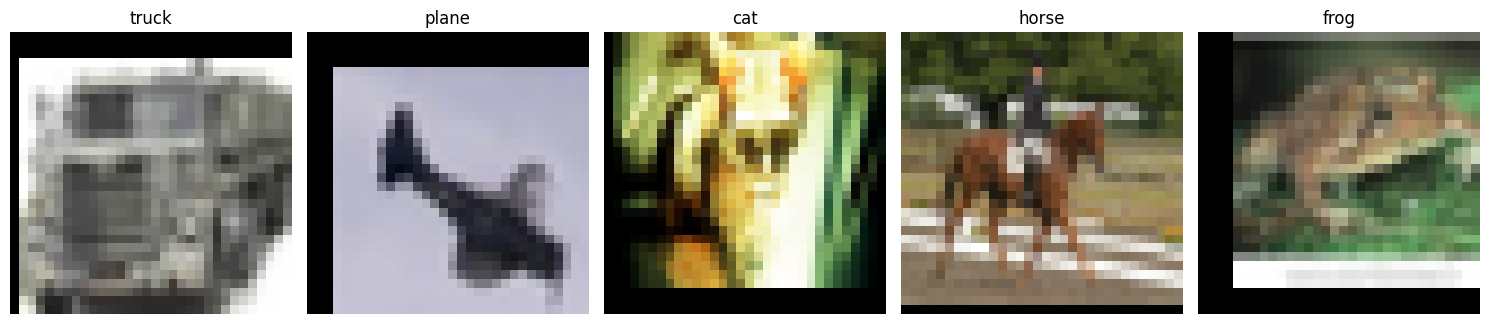

Showing 5 sample images from dataset

----------------------------------------
Training lenet on cifar10
----------------------------------------
Model: lenet
Number of parameters: 83126
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.8506 Acc: 0.3105


val - Epoch 1/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6670 Acc: 0.3792

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.5845 Acc: 0.4177


val - Epoch 2/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5543 Acc: 0.4372

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.4811 Acc: 0.4613


val - Epoch 3/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4363 Acc: 0.4812

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.4040 Acc: 0.4904


val - Epoch 4/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3542 Acc: 0.5116

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3407 Acc: 0.5163


val - Epoch 5/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3512 Acc: 0.5078

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.2925 Acc: 0.5348


val - Epoch 6/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2649 Acc: 0.5454

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.2553 Acc: 0.5490


val - Epoch 7/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2513 Acc: 0.5584

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1925 Acc: 0.5738


val - Epoch 8/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2012 Acc: 0.5732

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1814 Acc: 0.5774


val - Epoch 9/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1933 Acc: 0.5740

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1731 Acc: 0.5817


val - Epoch 10/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1855 Acc: 0.5774

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1715 Acc: 0.5791


val - Epoch 11/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1872 Acc: 0.5772

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1608 Acc: 0.5855


val - Epoch 12/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1735 Acc: 0.5814

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1578 Acc: 0.5856


val - Epoch 13/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1772 Acc: 0.5768

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1537 Acc: 0.5882


val - Epoch 14/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1851 Acc: 0.5756

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1446 Acc: 0.5924


val - Epoch 15/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1699 Acc: 0.5814

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1515 Acc: 0.5898


val - Epoch 16/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1745 Acc: 0.5786

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1490 Acc: 0.5880


val - Epoch 17/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1679 Acc: 0.5804

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1407 Acc: 0.5919


val - Epoch 18/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1519 Acc: 0.5858

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1443 Acc: 0.5913


val - Epoch 19/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1636 Acc: 0.5766

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1426 Acc: 0.5901


val - Epoch 20/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1642 Acc: 0.5876

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1430 Acc: 0.5926


val - Epoch 21/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1683 Acc: 0.5852

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1431 Acc: 0.5932


val - Epoch 22/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1750 Acc: 0.5800

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1443 Acc: 0.5907


val - Epoch 23/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1663 Acc: 0.5802

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1446 Acc: 0.5924


val - Epoch 24/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1693 Acc: 0.5842

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1416 Acc: 0.5929


val - Epoch 25/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1692 Acc: 0.5870

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1423 Acc: 0.5930


val - Epoch 26/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1531 Acc: 0.5904

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1427 Acc: 0.5930


val - Epoch 27/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1671 Acc: 0.5836

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1441 Acc: 0.5926


val - Epoch 28/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1633 Acc: 0.5866

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1383 Acc: 0.5940


val - Epoch 29/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1644 Acc: 0.5894

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1424 Acc: 0.5934


val - Epoch 30/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1776 Acc: 0.5764

Training complete in 17m 53s
Best val Acc: 0.5904


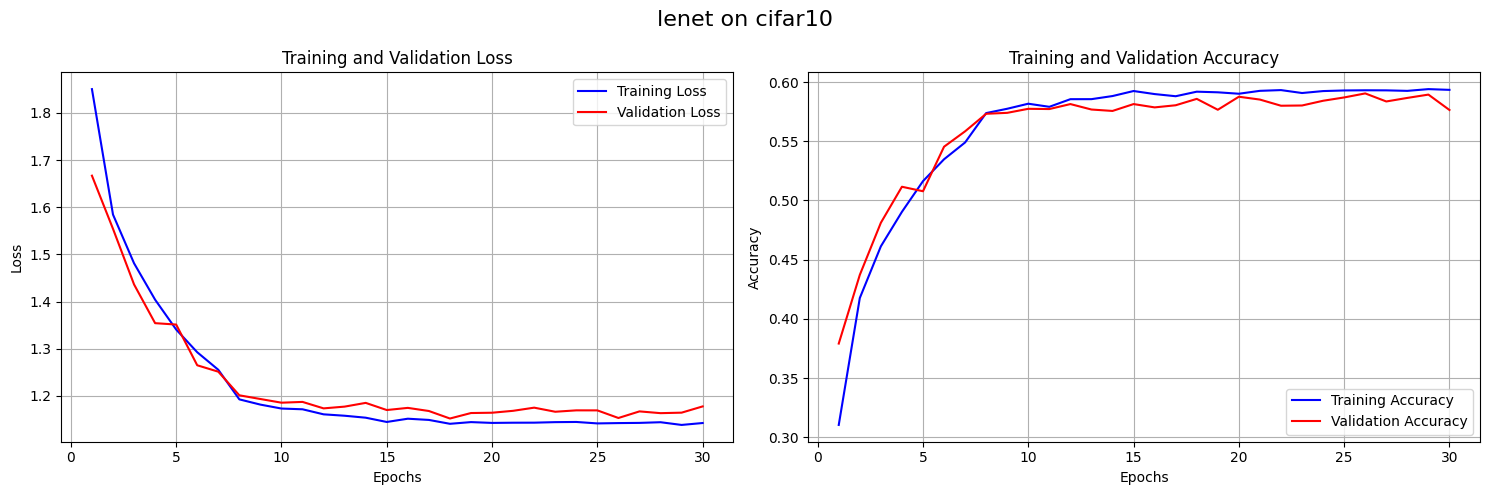

Training history plot saved to ./results/lenet_on_cifar10_history.png


Evaluating on cifar10:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.0945 Acc: 0.6104


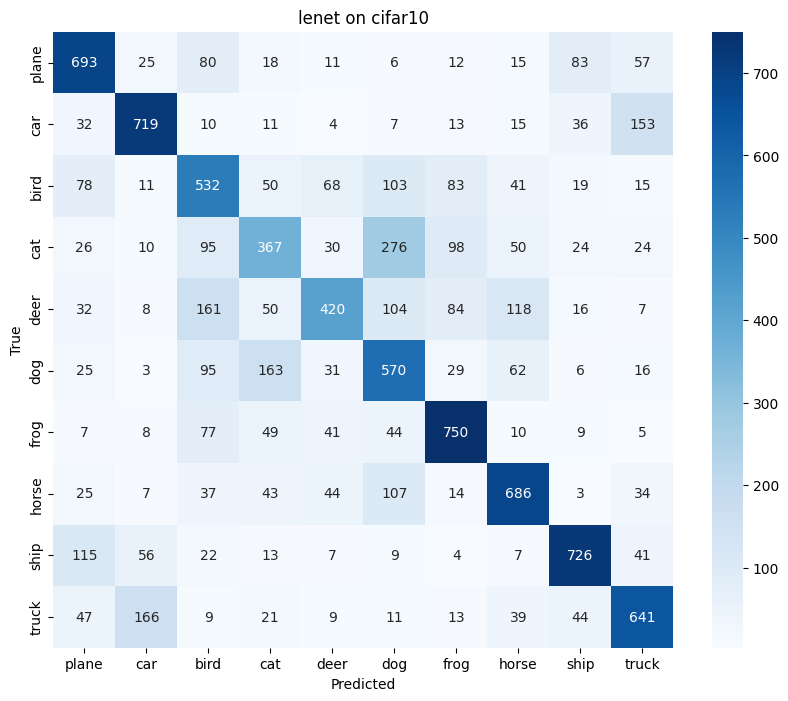

Confusion matrix plot saved to ./results/lenet_on_cifar10_confusion_matrix.png
Classification report saved to ./results/lenet_on_cifar10_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
plane,0.641667,0.6930,0.666346,1000.0000
car,0.709773,0.7190,0.714357,1000.0000
bird,0.475850,0.5320,0.502361,1000.0000
cat,0.467516,0.3670,0.411204,1000.0000
deer,0.631579,0.4200,0.504505,1000.0000
dog,0.460792,0.5700,0.509611,1000.0000
frog,0.681818,0.7500,0.714286,1000.0000
horse,0.657718,0.6860,0.671561,1000.0000
ship,0.751553,0.7260,0.738555,1000.0000
truck,0.645519,0.6410,0.643251,1000.0000



----------------------------------------
Training resnet18 on cifar10
----------------------------------------
Model: resnet18
Number of parameters: 11173962
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.5134 Acc: 0.4453


val - Epoch 1/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3006 Acc: 0.5414

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.0537 Acc: 0.6217


val - Epoch 2/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.9602 Acc: 0.6596

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.8647 Acc: 0.6938


val - Epoch 3/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.8567 Acc: 0.7024

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7272 Acc: 0.7457


val - Epoch 4/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.8647 Acc: 0.7090

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.6279 Acc: 0.7793


val - Epoch 5/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7780 Acc: 0.7318

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.5692 Acc: 0.8026


val - Epoch 6/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.6005 Acc: 0.7924

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.5130 Acc: 0.8216


val - Epoch 7/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.5692 Acc: 0.8086

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.3615 Acc: 0.8752


val - Epoch 8/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3863 Acc: 0.8694

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.3202 Acc: 0.8885


val - Epoch 9/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3621 Acc: 0.8710

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2979 Acc: 0.8969


val - Epoch 10/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3599 Acc: 0.8774

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2796 Acc: 0.9039


val - Epoch 11/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3493 Acc: 0.8816

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2625 Acc: 0.9090


val - Epoch 12/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3498 Acc: 0.8836

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2501 Acc: 0.9124


val - Epoch 13/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3360 Acc: 0.8850

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2367 Acc: 0.9175


val - Epoch 14/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3585 Acc: 0.8820

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2038 Acc: 0.9291


val - Epoch 15/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3125 Acc: 0.8954

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1926 Acc: 0.9331


val - Epoch 16/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3180 Acc: 0.8938

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1886 Acc: 0.9348


val - Epoch 17/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3288 Acc: 0.8936

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1883 Acc: 0.9339


val - Epoch 18/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3228 Acc: 0.8972

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1840 Acc: 0.9359


val - Epoch 19/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3243 Acc: 0.8960

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1829 Acc: 0.9371


val - Epoch 20/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3346 Acc: 0.8886

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1804 Acc: 0.9380


val - Epoch 21/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3271 Acc: 0.8914

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1750 Acc: 0.9382


val - Epoch 22/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3281 Acc: 0.8946

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1741 Acc: 0.9398


val - Epoch 23/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3191 Acc: 0.8960

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1753 Acc: 0.9395


val - Epoch 24/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3307 Acc: 0.8914

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1722 Acc: 0.9415


val - Epoch 25/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3275 Acc: 0.8954

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1695 Acc: 0.9409


val - Epoch 26/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3356 Acc: 0.8930

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1750 Acc: 0.9393


val - Epoch 27/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3324 Acc: 0.8942

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1719 Acc: 0.9409


val - Epoch 28/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3205 Acc: 0.8986

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1719 Acc: 0.9404


val - Epoch 29/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3132 Acc: 0.8992

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1716 Acc: 0.9400


val - Epoch 30/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3204 Acc: 0.8952

Training complete in 197m 45s
Best val Acc: 0.8992


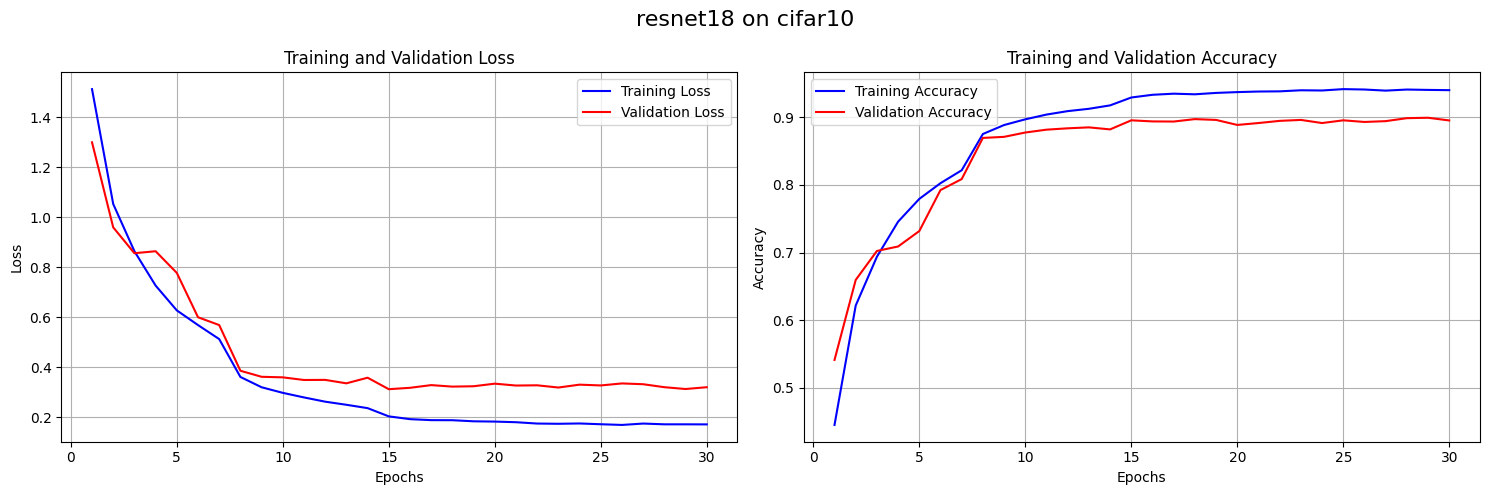

Training history plot saved to ./results/resnet18_on_cifar10_history.png


Evaluating on cifar10:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.3455 Acc: 0.8928


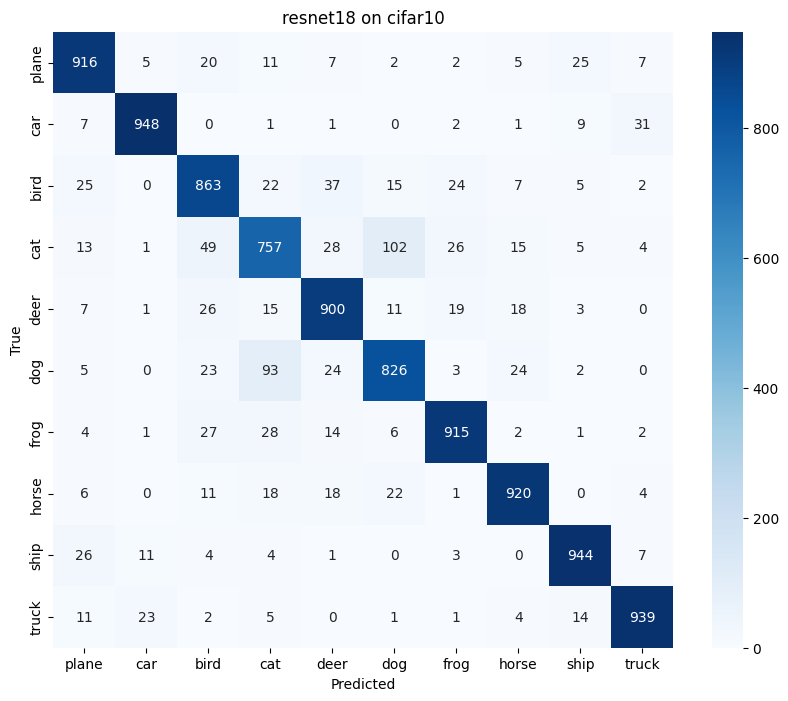

Confusion matrix plot saved to ./results/resnet18_on_cifar10_confusion_matrix.png
Classification report saved to ./results/resnet18_on_cifar10_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
plane,0.898039,0.9160,0.906931,1000.0000
car,0.957576,0.9480,0.952764,1000.0000
bird,0.841951,0.8630,0.852346,1000.0000
cat,0.793501,0.7570,0.774821,1000.0000
deer,0.873786,0.9000,0.886700,1000.0000
dog,0.838579,0.8260,0.832242,1000.0000
frog,0.918675,0.9150,0.916834,1000.0000
horse,0.923695,0.9200,0.921844,1000.0000
ship,0.936508,0.9440,0.940239,1000.0000
truck,0.942771,0.9390,0.940882,1000.0000



----------------------------------------
Training customcnn on cifar10
----------------------------------------
Model: customcnn
Number of parameters: 330506
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.5837 Acc: 0.4159


val - Epoch 1/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4431 Acc: 0.4860

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.2748 Acc: 0.5408


val - Epoch 2/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1638 Acc: 0.5844

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1602 Acc: 0.5857


val - Epoch 3/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1019 Acc: 0.6062

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.0825 Acc: 0.6164


val - Epoch 4/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.0211 Acc: 0.6310

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.0356 Acc: 0.6334


val - Epoch 5/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.0208 Acc: 0.6362

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.9780 Acc: 0.6574


val - Epoch 6/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.9031 Acc: 0.6766

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.9333 Acc: 0.6749


val - Epoch 7/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.8961 Acc: 0.6766

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.8403 Acc: 0.7067


val - Epoch 8/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7665 Acc: 0.7254

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.8180 Acc: 0.7172


val - Epoch 9/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7636 Acc: 0.7230

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.8032 Acc: 0.7208


val - Epoch 10/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7634 Acc: 0.7262

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7982 Acc: 0.7205


val - Epoch 11/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7600 Acc: 0.7304

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7943 Acc: 0.7233


val - Epoch 12/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7425 Acc: 0.7372

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7788 Acc: 0.7299


val - Epoch 13/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7305 Acc: 0.7442

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7788 Acc: 0.7300


val - Epoch 14/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7356 Acc: 0.7372

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7652 Acc: 0.7349


val - Epoch 15/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7338 Acc: 0.7306

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7618 Acc: 0.7343


val - Epoch 16/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7233 Acc: 0.7424

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7670 Acc: 0.7339


val - Epoch 17/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7175 Acc: 0.7398

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7584 Acc: 0.7374


val - Epoch 18/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7183 Acc: 0.7438

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7618 Acc: 0.7347


val - Epoch 19/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7196 Acc: 0.7446

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7604 Acc: 0.7343


val - Epoch 20/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7149 Acc: 0.7430

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7587 Acc: 0.7364


val - Epoch 21/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7257 Acc: 0.7396

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7568 Acc: 0.7360


val - Epoch 22/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7144 Acc: 0.7466

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7590 Acc: 0.7380


val - Epoch 23/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7271 Acc: 0.7364

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7537 Acc: 0.7395


val - Epoch 24/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7178 Acc: 0.7416

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7537 Acc: 0.7378


val - Epoch 25/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7233 Acc: 0.7408

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7537 Acc: 0.7396


val - Epoch 26/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7157 Acc: 0.7420

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7530 Acc: 0.7398


val - Epoch 27/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7219 Acc: 0.7438

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7575 Acc: 0.7356


val - Epoch 28/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7250 Acc: 0.7402

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7522 Acc: 0.7393


val - Epoch 29/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7241 Acc: 0.7436

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.7544 Acc: 0.7362


val - Epoch 30/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7206 Acc: 0.7372

Training complete in 11m 46s
Best val Acc: 0.7466


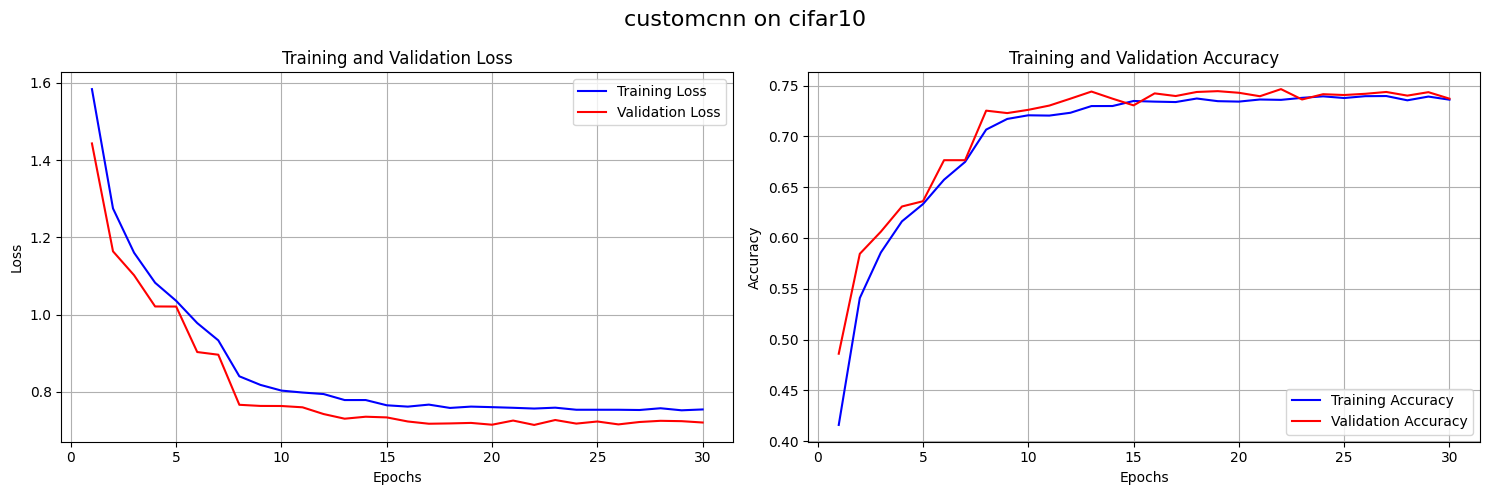

Training history plot saved to ./results/customcnn_on_cifar10_history.png


Evaluating on cifar10:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.6884 Acc: 0.7584


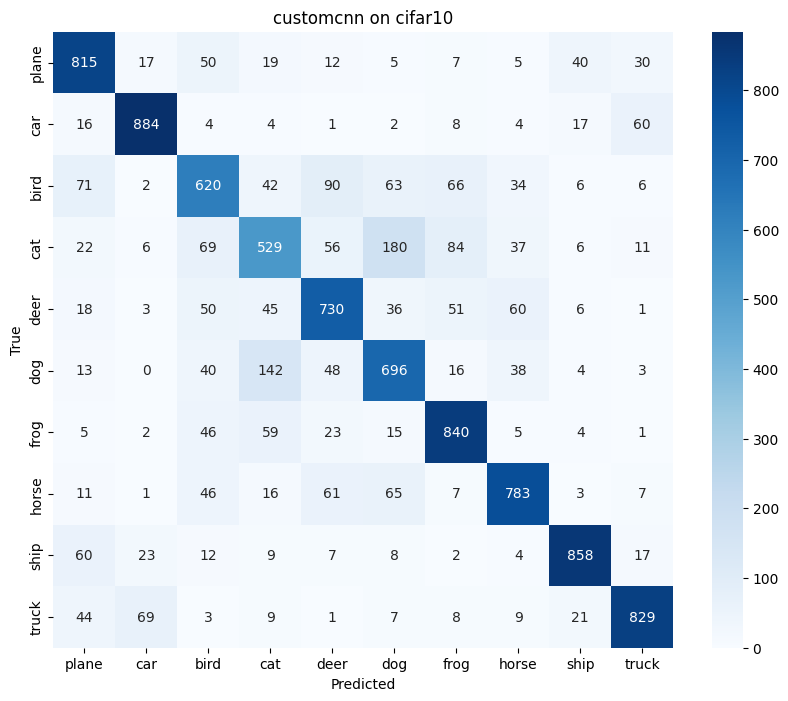

Confusion matrix plot saved to ./results/customcnn_on_cifar10_confusion_matrix.png
Classification report saved to ./results/customcnn_on_cifar10_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
plane,0.758140,0.8150,0.785542,1000.0000
car,0.877855,0.8840,0.880917,1000.0000
bird,0.659574,0.6200,0.639175,1000.0000
cat,0.605263,0.5290,0.564568,1000.0000
deer,0.709427,0.7300,0.719566,1000.0000
dog,0.646240,0.6960,0.670197,1000.0000
frog,0.771350,0.8400,0.804213,1000.0000
horse,0.799796,0.7830,0.791309,1000.0000
ship,0.889119,0.8580,0.873282,1000.0000
truck,0.859067,0.8290,0.843766,1000.0000


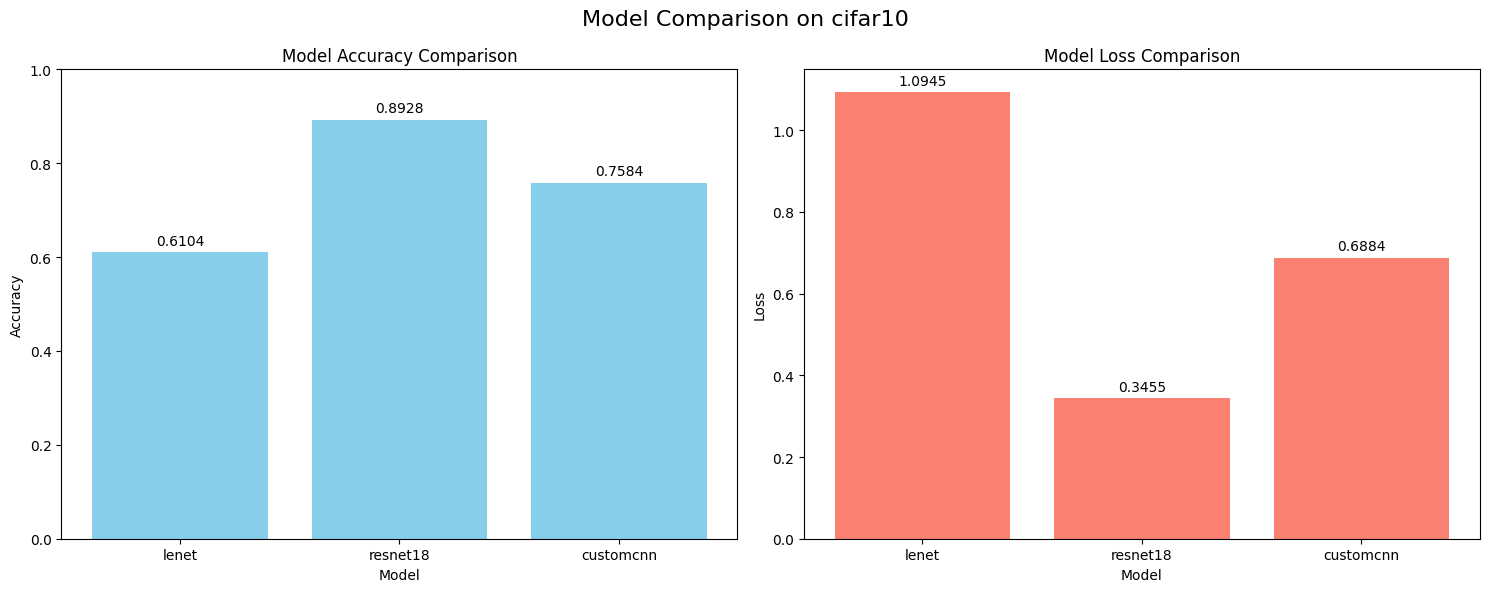

Model comparison plot saved to ./results/Model_Comparison_on_cifar10_comparison.png

Processing dataset: svhn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182M/182M [00:12<00:00, 15.2MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64.3M/64.3M [00:07<00:00, 8.85MB/s]


Dataset: SVHN
Number of training samples: 65932
Number of validation samples: 7325
Number of testing samples: 26032


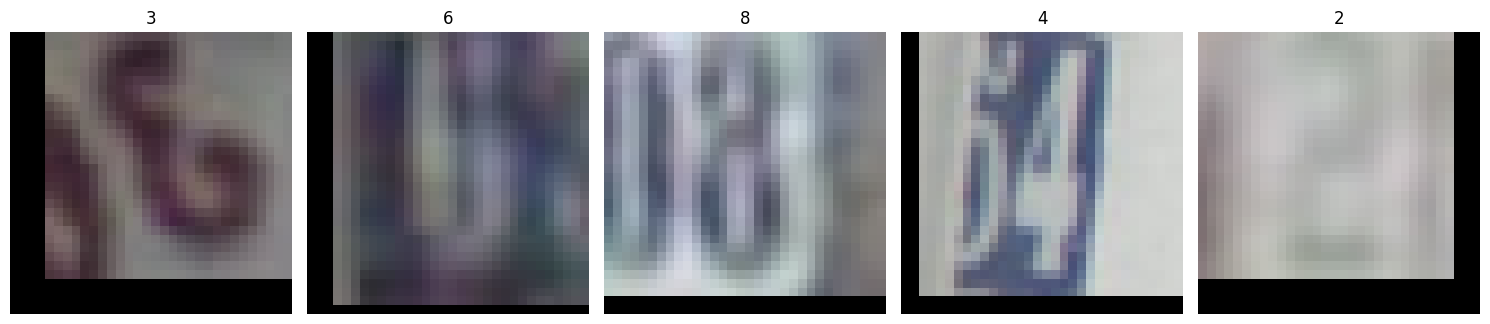

Showing 5 sample images from dataset

----------------------------------------
Training lenet on svhn
----------------------------------------
Model: lenet
Number of parameters: 83126
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.8638 Acc: 0.3417


val - Epoch 1/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.4769 Acc: 0.4852

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.2804 Acc: 0.5644


val - Epoch 2/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.2338 Acc: 0.5848

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0621 Acc: 0.6463


val - Epoch 3/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0180 Acc: 0.6680

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.9405 Acc: 0.6908


val - Epoch 4/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.9034 Acc: 0.7058

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.8625 Acc: 0.7184


val - Epoch 5/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.8260 Acc: 0.7319

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.8044 Acc: 0.7402


val - Epoch 6/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.7957 Acc: 0.7457

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.7657 Acc: 0.7514


val - Epoch 7/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.7568 Acc: 0.7555

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.7029 Acc: 0.7717


val - Epoch 8/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.7018 Acc: 0.7734

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6922 Acc: 0.7779


val - Epoch 9/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6940 Acc: 0.7779

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6876 Acc: 0.7797


val - Epoch 10/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.7033 Acc: 0.7817

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6770 Acc: 0.7833


val - Epoch 11/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6828 Acc: 0.7760

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6773 Acc: 0.7809


val - Epoch 12/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6779 Acc: 0.7866

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6717 Acc: 0.7837


val - Epoch 13/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6718 Acc: 0.7846

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6682 Acc: 0.7860


val - Epoch 14/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6656 Acc: 0.7884

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6619 Acc: 0.7878


val - Epoch 15/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6717 Acc: 0.7842

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6586 Acc: 0.7890


val - Epoch 16/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6607 Acc: 0.7915

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6627 Acc: 0.7882


val - Epoch 17/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6656 Acc: 0.7847

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6589 Acc: 0.7886


val - Epoch 18/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6665 Acc: 0.7818

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6628 Acc: 0.7887


val - Epoch 19/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6567 Acc: 0.7929

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6569 Acc: 0.7885


val - Epoch 20/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6705 Acc: 0.7911

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6590 Acc: 0.7890


val - Epoch 21/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6646 Acc: 0.7870

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6609 Acc: 0.7896


val - Epoch 22/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6640 Acc: 0.7888

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6572 Acc: 0.7899


val - Epoch 23/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6695 Acc: 0.7848

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6577 Acc: 0.7891


val - Epoch 24/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6644 Acc: 0.7892

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6543 Acc: 0.7908


val - Epoch 25/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6627 Acc: 0.7903

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6562 Acc: 0.7892


val - Epoch 26/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6687 Acc: 0.7846

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6542 Acc: 0.7901


val - Epoch 27/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6618 Acc: 0.7944

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6606 Acc: 0.7888


val - Epoch 28/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6590 Acc: 0.7903

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6575 Acc: 0.7900


val - Epoch 29/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6641 Acc: 0.7865

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6594 Acc: 0.7881


val - Epoch 30/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6626 Acc: 0.7885

Training complete in 11m 25s
Best val Acc: 0.7944


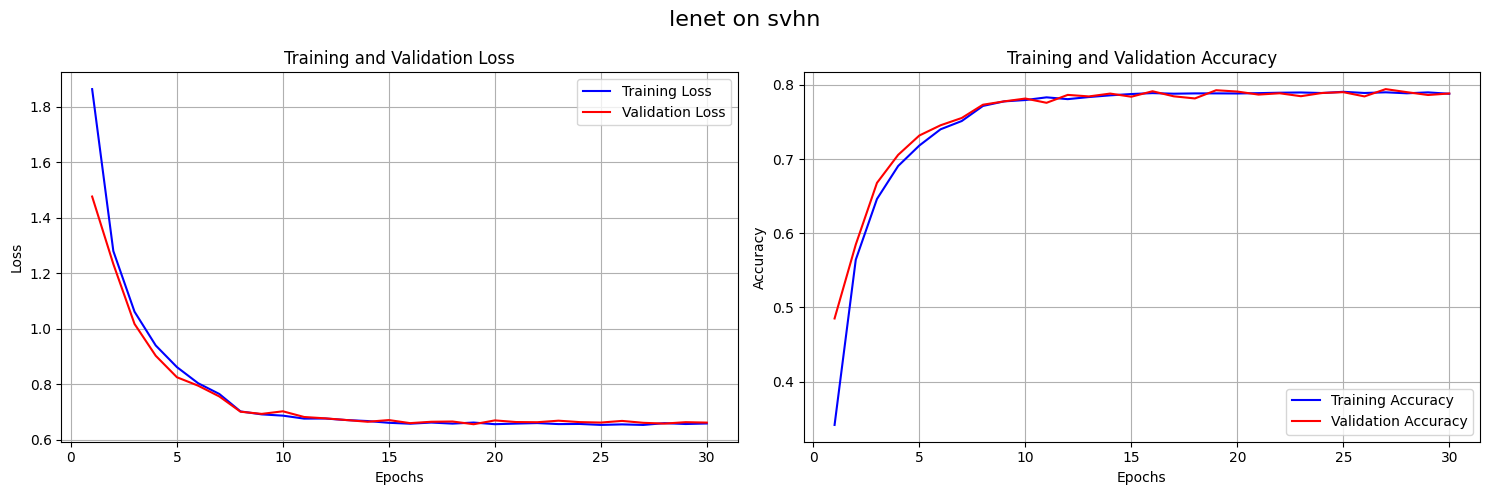

Training history plot saved to ./results/lenet_on_svhn_history.png


Evaluating on svhn:   0%|          | 0/204 [00:00<?, ?it/s]

Test Loss: 0.5643 Acc: 0.8215


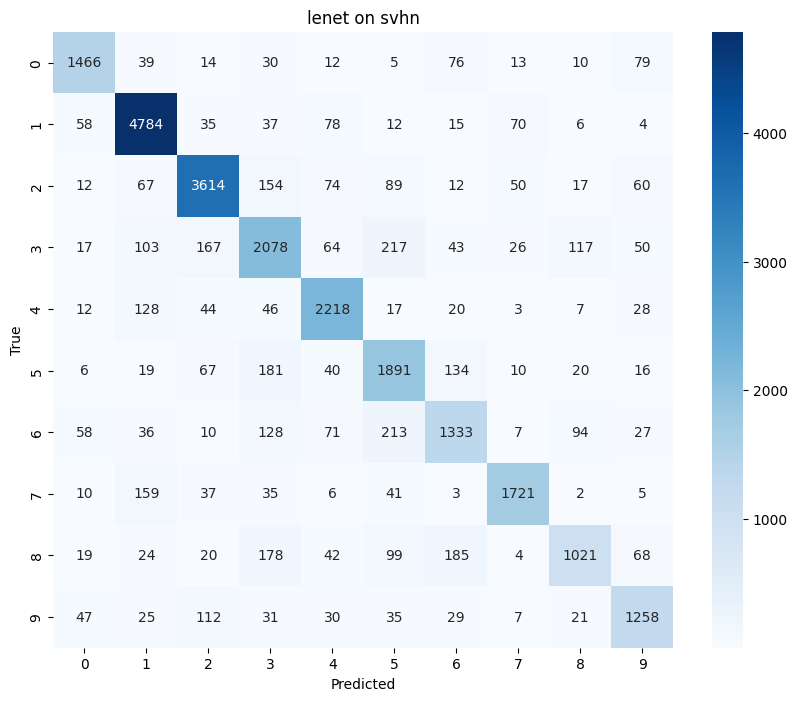

Confusion matrix plot saved to ./results/lenet_on_svhn_confusion_matrix.png
Classification report saved to ./results/lenet_on_svhn_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
0,0.859824,0.840596,0.850101,1744.000000
1,0.888559,0.938223,0.912716,5099.000000
2,0.877184,0.871053,0.874108,4149.000000
3,0.717046,0.721027,0.719031,2882.000000
4,0.841746,0.879112,0.860023,2523.000000
5,0.722031,0.793205,0.755946,2384.000000
6,0.720541,0.674254,0.696629,1977.000000
7,0.900576,0.852402,0.875827,2019.000000
8,0.776426,0.615060,0.686387,1660.000000
9,0.788715,0.788715,0.788715,1595.000000



----------------------------------------
Training resnet18 on svhn
----------------------------------------
Model: resnet18
Number of parameters: 11173962
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0463 Acc: 0.6430


val - Epoch 1/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6226 Acc: 0.8091

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4134 Acc: 0.8729


val - Epoch 2/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.4535 Acc: 0.8587

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.3514 Acc: 0.8933


val - Epoch 3/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3688 Acc: 0.8878

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.3218 Acc: 0.9027


val - Epoch 4/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3742 Acc: 0.8861

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.3020 Acc: 0.9096


val - Epoch 5/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.4977 Acc: 0.8497

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.2876 Acc: 0.9144


val - Epoch 6/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3767 Acc: 0.8833

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.2754 Acc: 0.9180


val - Epoch 7/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.2993 Acc: 0.9130

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1950 Acc: 0.9448


val - Epoch 8/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.2076 Acc: 0.9406

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1743 Acc: 0.9515


val - Epoch 9/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1977 Acc: 0.9450

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1682 Acc: 0.9536


val - Epoch 10/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1932 Acc: 0.9469

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1603 Acc: 0.9558


val - Epoch 11/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1875 Acc: 0.9451

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1534 Acc: 0.9572


val - Epoch 12/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1825 Acc: 0.9465

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1484 Acc: 0.9587


val - Epoch 13/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1799 Acc: 0.9494

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1420 Acc: 0.9609


val - Epoch 14/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1836 Acc: 0.9491

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1259 Acc: 0.9663


val - Epoch 15/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1785 Acc: 0.9499

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1220 Acc: 0.9673


val - Epoch 16/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1773 Acc: 0.9511

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1195 Acc: 0.9681


val - Epoch 17/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1799 Acc: 0.9506

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1190 Acc: 0.9686


val - Epoch 18/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1784 Acc: 0.9502

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1185 Acc: 0.9683


val - Epoch 19/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1816 Acc: 0.9495

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1156 Acc: 0.9693


val - Epoch 20/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1815 Acc: 0.9487

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1137 Acc: 0.9697


val - Epoch 21/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1764 Acc: 0.9518

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1118 Acc: 0.9710


val - Epoch 22/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1739 Acc: 0.9536

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1122 Acc: 0.9704


val - Epoch 23/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1730 Acc: 0.9525

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1115 Acc: 0.9707


val - Epoch 24/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1830 Acc: 0.9480

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1120 Acc: 0.9702


val - Epoch 25/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1788 Acc: 0.9504

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1110 Acc: 0.9707


val - Epoch 26/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1815 Acc: 0.9503

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1119 Acc: 0.9706


val - Epoch 27/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1812 Acc: 0.9509

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1095 Acc: 0.9715


val - Epoch 28/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1738 Acc: 0.9509

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1097 Acc: 0.9711


val - Epoch 29/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1771 Acc: 0.9533

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1108 Acc: 0.9710


val - Epoch 30/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1770 Acc: 0.9504

Training complete in 283m 60s
Best val Acc: 0.9536


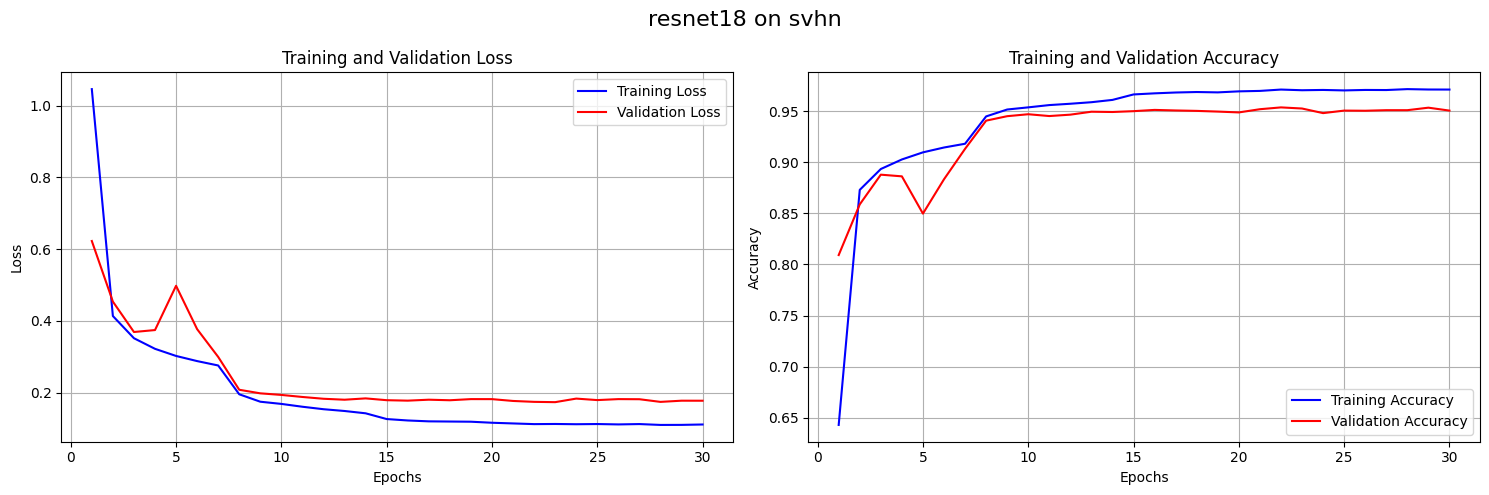

Training history plot saved to ./results/resnet18_on_svhn_history.png


Evaluating on svhn:   0%|          | 0/204 [00:00<?, ?it/s]

Test Loss: 0.1524 Acc: 0.9586


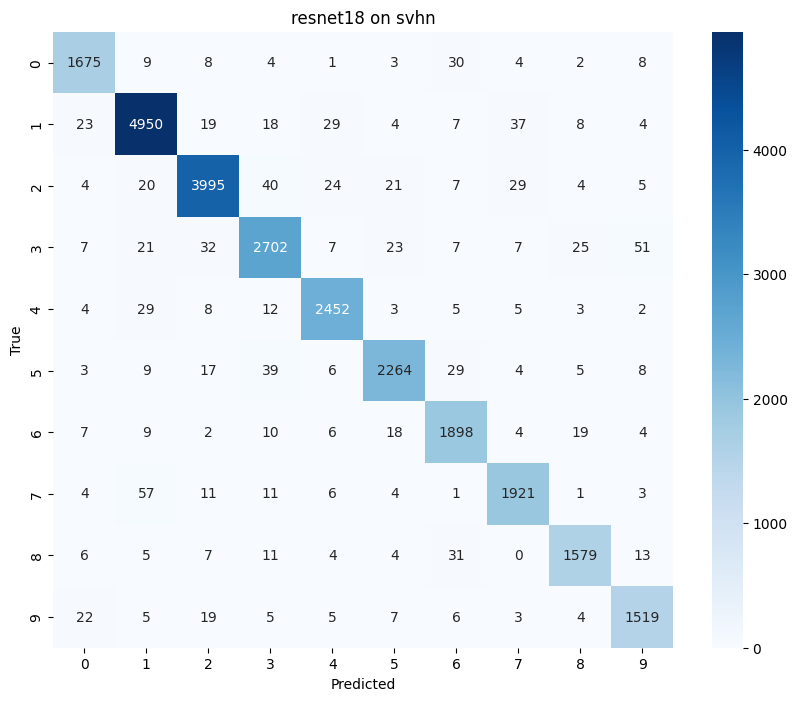

Confusion matrix plot saved to ./results/resnet18_on_svhn_confusion_matrix.png
Classification report saved to ./results/resnet18_on_svhn_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
0,0.954416,0.960436,0.957416,1744.000000
1,0.967931,0.970779,0.969353,5099.000000
2,0.970131,0.962883,0.966493,4149.000000
3,0.947405,0.937543,0.942449,2882.000000
4,0.965354,0.971859,0.968596,2523.000000
5,0.962994,0.949664,0.956283,2384.000000
6,0.939139,0.960040,0.949475,1977.000000
7,0.953823,0.951461,0.952641,2019.000000
8,0.956970,0.951205,0.954079,1660.000000
9,0.939394,0.952351,0.945828,1595.000000



----------------------------------------
Training customcnn on svhn
----------------------------------------
Model: customcnn
Number of parameters: 330506
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.6896 Acc: 0.4024


val - Epoch 1/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0971 Acc: 0.6296

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0443 Acc: 0.6475


val - Epoch 2/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.8126 Acc: 0.7387

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.8676 Acc: 0.7152


val - Epoch 3/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6509 Acc: 0.7941

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.7774 Acc: 0.7496


val - Epoch 4/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6044 Acc: 0.8127

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.7199 Acc: 0.7700


val - Epoch 5/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.5671 Acc: 0.8213

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6757 Acc: 0.7869


val - Epoch 6/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.5381 Acc: 0.8287

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6340 Acc: 0.8009


val - Epoch 7/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.5058 Acc: 0.8433

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.5687 Acc: 0.8243


val - Epoch 8/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.4314 Acc: 0.8659

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.5436 Acc: 0.8321


val - Epoch 9/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.4218 Acc: 0.8730

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.5305 Acc: 0.8395


val - Epoch 10/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.4121 Acc: 0.8743

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.5199 Acc: 0.8426


val - Epoch 11/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.4096 Acc: 0.8728

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.5093 Acc: 0.8465


val - Epoch 12/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.4112 Acc: 0.8737

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.5038 Acc: 0.8483


val - Epoch 13/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.4002 Acc: 0.8785

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4969 Acc: 0.8517


val - Epoch 14/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3951 Acc: 0.8793

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4872 Acc: 0.8546


val - Epoch 15/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3979 Acc: 0.8763

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4856 Acc: 0.8557


val - Epoch 16/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3980 Acc: 0.8775

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4796 Acc: 0.8577


val - Epoch 17/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3934 Acc: 0.8838

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4829 Acc: 0.8553


val - Epoch 18/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3881 Acc: 0.8829

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4788 Acc: 0.8561


val - Epoch 19/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3878 Acc: 0.8801

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4794 Acc: 0.8586


val - Epoch 20/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3872 Acc: 0.8820

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4778 Acc: 0.8571


val - Epoch 21/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3857 Acc: 0.8818

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4779 Acc: 0.8587


val - Epoch 22/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3825 Acc: 0.8838

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4744 Acc: 0.8593


val - Epoch 23/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3964 Acc: 0.8782

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4784 Acc: 0.8598


val - Epoch 24/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3845 Acc: 0.8827

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4771 Acc: 0.8577


val - Epoch 25/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3892 Acc: 0.8803

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4736 Acc: 0.8594


val - Epoch 26/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3921 Acc: 0.8775

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4717 Acc: 0.8605


val - Epoch 27/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3909 Acc: 0.8816

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4732 Acc: 0.8590


val - Epoch 28/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3876 Acc: 0.8822

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4747 Acc: 0.8583


val - Epoch 29/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3917 Acc: 0.8790

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4780 Acc: 0.8581


val - Epoch 30/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3875 Acc: 0.8827

Training complete in 14m 15s
Best val Acc: 0.8838


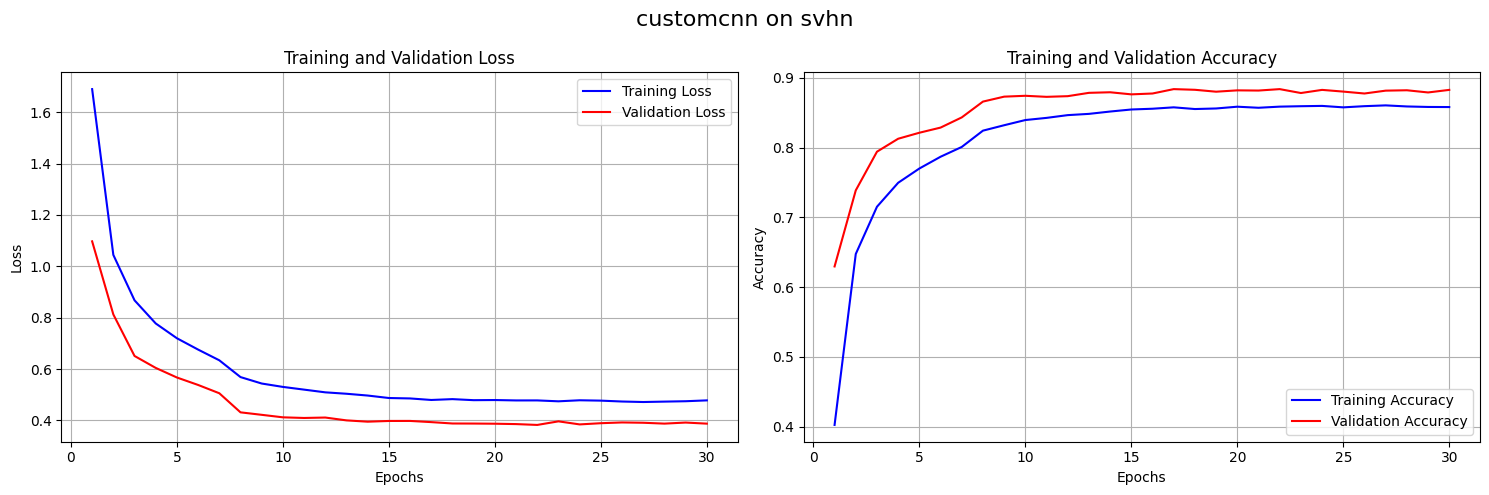

Training history plot saved to ./results/customcnn_on_svhn_history.png


Evaluating on svhn:   0%|          | 0/204 [00:00<?, ?it/s]

Test Loss: 0.3703 Acc: 0.8875


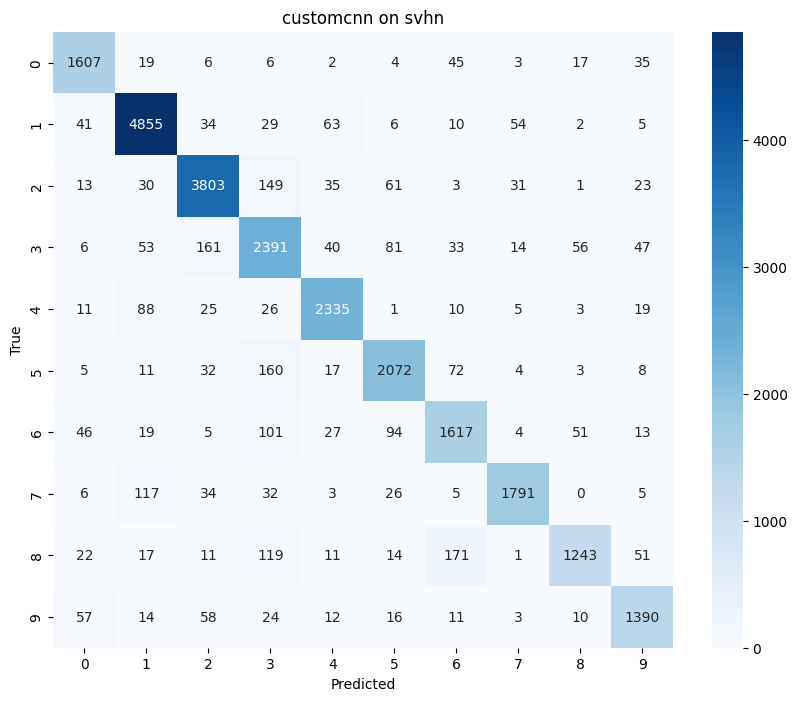

Confusion matrix plot saved to ./results/customcnn_on_svhn_confusion_matrix.png
Classification report saved to ./results/customcnn_on_svhn_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
0,0.885888,0.921445,0.903316,1744.000000
1,0.929542,0.952147,0.940709,5099.000000
2,0.912209,0.916606,0.914403,4149.000000
3,0.787290,0.829632,0.807907,2882.000000
4,0.917485,0.925486,0.921468,2523.000000
5,0.872421,0.869128,0.870771,2384.000000
6,0.817906,0.817906,0.817906,1977.000000
7,0.937696,0.887073,0.911682,2019.000000
8,0.896825,0.748795,0.816152,1660.000000
9,0.870927,0.871473,0.871200,1595.000000


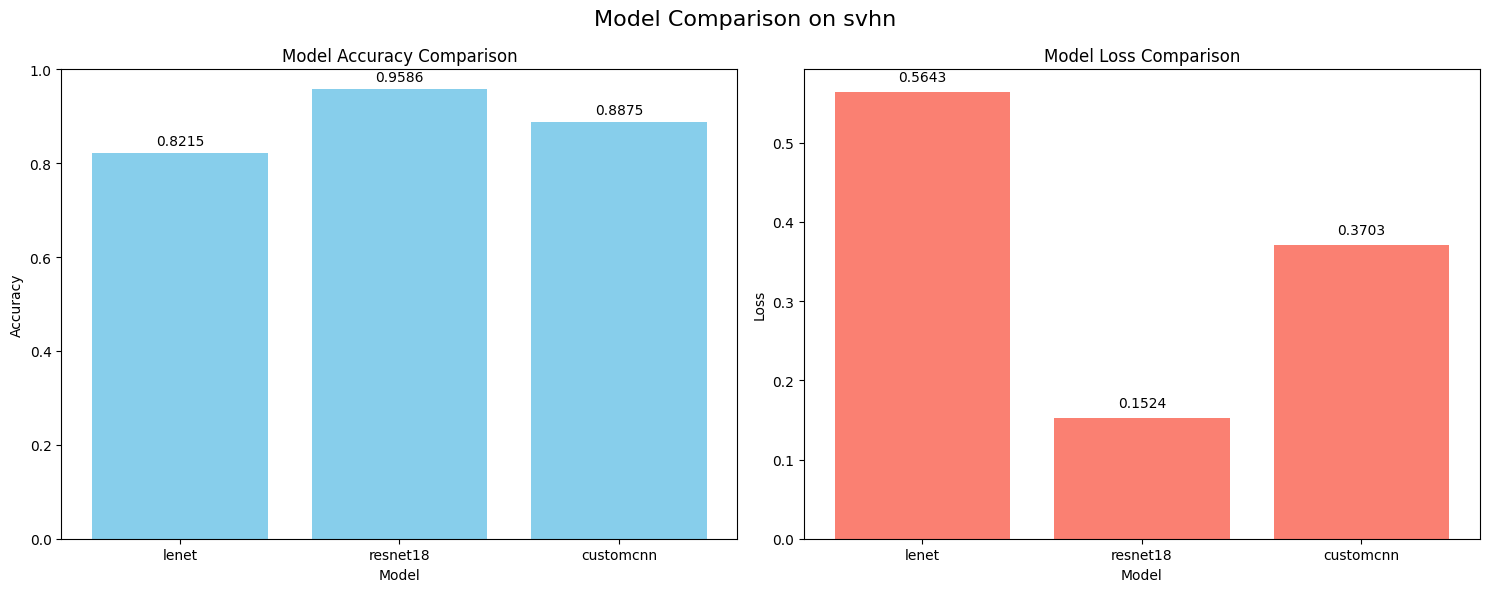

Model comparison plot saved to ./results/Model_Comparison_on_svhn_comparison.png

Final Results:

Dataset: cifar10
  lenet: Accuracy = 0.6104, Loss = 1.0945
  resnet18: Accuracy = 0.8928, Loss = 0.3455
  customcnn: Accuracy = 0.7584, Loss = 0.6884

Dataset: svhn
  lenet: Accuracy = 0.8215, Loss = 0.5643
  resnet18: Accuracy = 0.9586, Loss = 0.1524
  customcnn: Accuracy = 0.8875, Loss = 0.3703


In [17]:
def run_experiment(dataset_names=['cifar10', 'svhn'], 
                  model_names=['lenet', 'resnet18', 'customcnn'],
                  batch_size=128, epochs=30, learning_rate=0.001, weight_decay=1e-4,
                  num_workers=2, save_dir='./results', log_step=100):
    """
    Run the complete experiment pipeline.
    
    Args:
        dataset_names (list): List of dataset names to use
        model_names (list): List of model names to train
        batch_size (int): Batch size for training
        epochs (int): Number of epochs to train
        learning_rate (float): Learning rate for optimization
        weight_decay (float): Weight decay (L2 penalty) for regularization
        num_workers (int): Number of worker threads for dataloaders
        save_dir (str): Directory to save results
        log_step (int): Frequency of logging to TensorBoard
    """
    # Results dictionary to store metrics for all models and datasets
    results = defaultdict(dict)
    
    # Iterate over datasets
    for dataset_name in dataset_names:
        print(f"\n{'='*50}")
        print(f"Processing dataset: {dataset_name}")
        print(f"{'='*50}")
        
        # Load dataset
        train_loader, val_loader, test_loader, dataset_info = get_datasets(
            dataset_name, batch_size=batch_size, num_workers=num_workers
        )
        
        # Visualize samples from the dataset
        visualize_dataset_samples(train_loader, dataset_info['classes'])
        
        # Create dataloader dictionary
        dataloaders = {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader
        }
        
        # Iterate over models
        for model_name in model_names:
            print(f"\n{'-'*40}")
            print(f"Training {model_name} on {dataset_name}")
            print(f"{'-'*40}")
            
            # Initialize model
            model = get_model(
                model_name, 
                num_classes=dataset_info['num_classes'],
                input_channels=dataset_info['input_channels']
            )
            model = model.to(device)
            
            # Print model summary
            print(f"Model: {model_name}")
            print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
            
            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            # Learning rate scheduler
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            
            # Train model
            model, history = train_model(
                model, dataloaders, criterion, optimizer, device,
                num_epochs=epochs, model_name=model_name, dataset_name=dataset_name,
                scheduler=scheduler, log_step=log_step, save_dir=save_dir
            )
            
            # Plot training history
            plot_training_history(
                history, f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            # Evaluate model on test set
            test_loss, test_acc, test_preds, test_labels = evaluate_model(
                model, test_loader, criterion, device, dataset_name=dataset_name
            )
            
            # Store results
            results[dataset_name][model_name] = {
                'accuracy': test_acc,
                'loss': test_loss
            }
            
            # Plot confusion matrix
            plot_confusion_matrix(
                test_labels, test_preds, dataset_info['classes'],
                f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            # Generate classification report
            report_df = generate_classification_report(
                test_labels, test_preds, dataset_info['classes'],
                f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            print("\nClassification Report:")
            display(report_df)
            
        # Compare models for each dataset
        compare_models(
            results[dataset_name], f"Model Comparison on {dataset_name}", save_dir=save_dir
        )
    
    # Print final results
    print("\nFinal Results:")
    for dataset_name in dataset_names:
        print(f"\nDataset: {dataset_name}")
        for model_name in model_names:
            print(f"  {model_name}: Accuracy = {results[dataset_name][model_name]['accuracy']:.4f}, "
                  f"Loss = {results[dataset_name][model_name]['loss']:.4f}")
    
    return results

results = run_experiment(
     dataset_names=['cifar10', 'svhn'],
     model_names=['lenet', 'resnet18', 'customcnn'],
     batch_size=128,
     epochs=30,  # Reduce for faster testing
     learning_rate=0.001,
     weight_decay=1e-4,
     num_workers=2,  # Adjust based on your CPU
     save_dir='./results'
 )

## Evaluating Trained Models

Dataset: SVHN
Number of training samples: 65932
Number of validation samples: 7325
Number of testing samples: 26032


Evaluating on svhn:   0%|          | 0/204 [00:00<?, ?it/s]

Test Loss: 0.1524 Acc: 0.9586


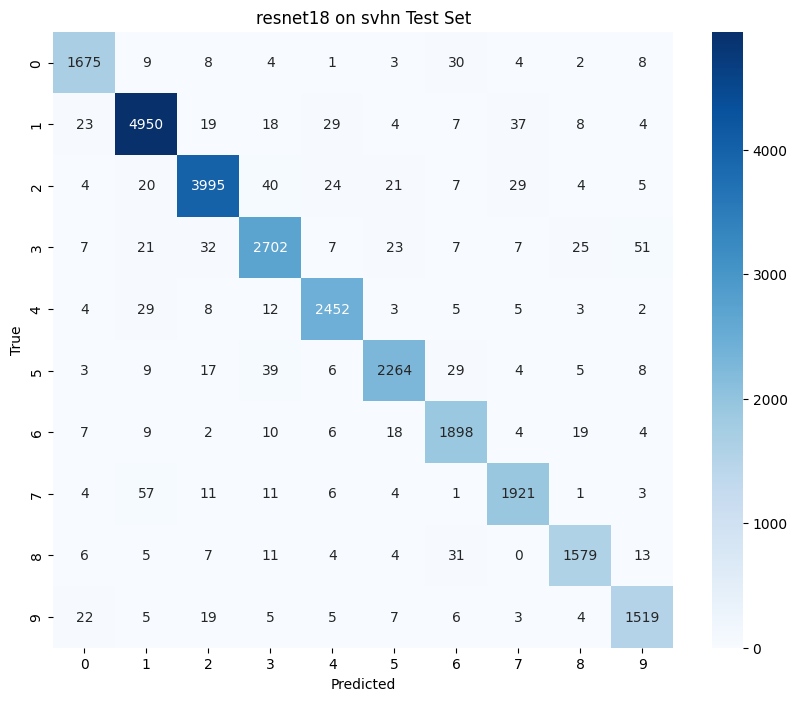

Confusion matrix plot saved to ./results/resnet18_on_svhn_Test_Set_confusion_matrix.png
Classification report saved to ./results/resnet18_on_svhn_Test_Set_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
0,0.954416,0.960436,0.957416,1744.000000
1,0.967931,0.970779,0.969353,5099.000000
2,0.970131,0.962883,0.966493,4149.000000
3,0.947405,0.937543,0.942449,2882.000000
4,0.965354,0.971859,0.968596,2523.000000
5,0.962994,0.949664,0.956283,2384.000000
6,0.939139,0.960040,0.949475,1977.000000
7,0.953823,0.951461,0.952641,2019.000000
8,0.956970,0.951205,0.954079,1660.000000
9,0.939394,0.952351,0.945828,1595.000000


In [18]:
def evaluate_trained_model(model_name, dataset_name, checkpoint_path):
    """
    Evaluate a trained model on test data.
    
    Args:
        model_name (str): Name of the model
        dataset_name (str): Name of the dataset
        checkpoint_path (str): Path to the checkpoint file
    """
    # Load dataset
    _, _, test_loader, dataset_info = get_datasets(
        dataset_name, batch_size=128, num_workers=2
    )
    
    # Initialize model
    model = get_model(
        model_name, 
        num_classes=dataset_info['num_classes'],
        input_channels=dataset_info['input_channels']
    )
    model = model.to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()
    
    # Evaluate model on test set
    test_loss, test_acc, test_preds, test_labels = evaluate_model(
        model, test_loader, criterion, device, dataset_name=dataset_name
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(
        test_labels, test_preds, dataset_info['classes'],
        f"{model_name} on {dataset_name} Test Set", save_dir='./results'
    )
    
    # Generate classification report
    report_df = generate_classification_report(
        test_labels, test_preds, dataset_info['classes'],
        f"{model_name} on {dataset_name} Test Set", save_dir='./results'
    )
    
    print("\nClassification Report:")
    display(report_df)
    
    return test_acc, test_loss

acc, loss = evaluate_trained_model(
     model_name='resnet18',
     dataset_name='svhn',
     checkpoint_path='./results/resnet18_svhn_best.pth'
)